## Portfolio Factor Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, SpectralEmbedding
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function block

### REPRESENTATION LEARNING METHODS
def linPCA(train_data, tune_data, n_components):
    """
    Function to apply linear PCA with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit linear PCA model
        tune_data (ndarray): dataset transformed by linear PCA model
        n_components (int): hyperparameter specifying number of components
    Output:
        Z (ndarray): tune_data transformed to PCA subspace
    """
    pca = PCA(n_components=n_components)
    pca.fit(train_data)
    Z = pca.transform(tune_data)
    
    return Z

def KPCA(train_data, tune_data, n_components, kernel='poly', gamma=None, degree=3):
    """
    Function to apply Kernel PCA with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit kernel PCA model
        tune_data (ndarray): dataset transformed by kernel PCA model
        n_components (int): hyperparameter specifying number of components
        kernel (str): kernel method; choose from {"poly" | "rbf" | "sigmoid" | "cosine"}
        gamma (int): gamma coefficient for rbf, poly, and sigmoid kerenels
        degree (int): degree of polynomial for poly kernel
    Output:
        Z (ndarray): tune_data transformed to PCA subspace
    """
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, degree = degree)
    kpca.fit(train_data)
    Z = kpca.transform(tune_data)
    
    return Z

def isomap(train_data, tune_data, n_components, n_neighbors):
    """
    Function to apply Isomap with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit Isomap model
        tune_data (ndarray): dataset transformed by Isomap model
        n_components (int): hyperparameter specifying number of components
        n_neighbors (int): hyperparameter specifying number of neighbors to construct initial mapping
    Output:
        Z (ndarray): tune_data transformed to subspace
    """
    embedding = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    embedding.fit(train_data)
    Z = embedding.transform(tune_data)
    
    return Z

def spectral(train_data, n_components, affinity, gamma = None, n_neighbors = None):
    """
    Function to apply SpectralEmbedding with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit Spectral Embedding model
        n_components (int): hyperparameter specifying number of components
        affinity (str): designation of affinity matrix; choose from {'nearest_neighbors'|'rbf'|'precomputed'}
        gamma(int): coefficient for rbf kernel, if used
        n_neighbors (int): hyperparameter specifying number of neighbors to construct knn map, if used

    Output:
        Z (ndarray): tune_data transformed to subspace
    """
    embedding = SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, affinity = affinity, gamma = gamma)
    Z= embedding.fit_transform(train_data)
    
    return Z
    
    
### REGRESSION TEST
def LinRegression(X_train,y_train, dev = False, X_test = None,y_test = None,autocor = None):
    """
    Runs simple linear regression on the dataset provided and returns the model's R^2 value.
    Input:
        X (DataFrame): predictor data
        y (DataFrame): outcome data
        autocor: number of periods for autocorrelation correction (default = None)
    Output:
        R^2 value for model (real)
    
    """
    if autocor:
        for i in range(1,autocor + 1):
            X_train.join(y.shift(i))
        X_train = X_train.iloc[autocor::,:] # removing the rows that don't have lagged returns
        y_train = y_train.iloc[autocor::]
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    if not dev:
        return reg.score(X_train, y_train)
    else:
        return reg.score(X_test,y_test)

### Import Data

Read in Excel file and specifically import net returns data

In [3]:
xls=pd.ExcelFile('Simple_Strategies_Returns.xlsx')
grossreturns = pd.read_excel(xls, 0)
netreturns = pd.read_excel(xls, 1)

In [4]:
#Keep all data, but get rid of factors with missing data
netreturns = netreturns.dropna(axis=1).copy()
netreturns['Month'] = pd.to_datetime(netreturns['Month'], format = '%Y%m')
netreturns['Month'] = netreturns['Month'].dt.to_period('M')
netreturns['Month'] = netreturns['Month'].astype('str')

grossreturns = grossreturns.dropna(axis=1).copy()
grossreturns['Month'] = pd.to_datetime(grossreturns['Month'], format = '%Y%m')
grossreturns['Month'] = grossreturns['Month'].dt.to_period('M')
grossreturns['Month'] = grossreturns['Month'].astype('str')

In [5]:
netreturns.shape

(606, 25)

Split data into 'new' and 'old' sections:  
'Old' section has 120 months of 26 factors  
'New' section has 486 months of 34 factors

In [6]:
# oldnetreturns = netreturns[netreturns.Month < 197307]
# oldnetreturns = oldnetreturns.reset_index(drop=True)
# oldnetreturns = oldnetreturns.dropna(axis=1)
# oldnetreturns['Month'] = pd.to_datetime(oldnetreturns['Month'], format = '%Y%m')
# oldnetreturns['Month'] = oldnetreturns['Month'].dt.to_period('M')
# oldnetreturns['Month'] = oldnetreturns['Month'].astype('str')

In [7]:
# newnetreturns = netreturns[netreturns.Month >= 197307]
# newnetreturns = newnetreturns.reset_index(drop=True)
# newnetreturns['Month'] = pd.to_datetime(newnetreturns['Month'], format = '%Y%m')
# newnetreturns['Month'] = newnetreturns['Month'].dt.to_period('M')
# newnetreturns['Month'] = newnetreturns['Month'].astype('str')

Fama-French Data

In [8]:
portfolios25 = pd.read_csv('25_Portfolios_5x5.CSV')
portfolios6 =pd.read_csv('6_Portfolios_2x3.CSV')

In [9]:
portfolios25.reset_index(inplace=True)

In [10]:
portfolios6['Month'] = pd.to_datetime(portfolios6['Month'], format = '%Y%m')
portfolios6['Month'] = portfolios6['Month'].dt.to_period('M')
portfolios6['Month'] = portfolios6['Month'].astype('str')

In [11]:
portfolios6.head()

,Month,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,1926-07,1.3724,0.9081,-0.0695,5.7168,1.9642,1.4222
1,1926-08,0.6095,1.5075,5.3842,2.7154,2.6838,6.3154
2,1926-09,-2.6779,-0.1359,-0.4374,1.4287,0.0709,-0.7967
3,1926-10,-3.5365,-4.3572,-2.0112,-3.5898,-2.3460,-4.0970
4,1926-11,3.1210,3.6608,2.0944,3.1292,2.8965,3.4614


In [12]:
ff_5 = pd.read_csv('FF_5_Factors')

In [13]:
ff_5_monthly = ff_5.loc[:665,].copy()
ff_5_monthly['Month'] = pd.to_datetime(ff_5_monthly['Month'], format = '%Y%m')
ff_5_monthly['Month'] = ff_5_monthly['Month'].dt.to_period('M')
ff_5_monthly['Month'] = ff_5_monthly['Month'].astype('str')

Company Stock Data

In [14]:
stocks = pd.read_csv('Company Stock Data.csv')
stocks = stocks.drop('company', axis = 1)
stocks['date'] = pd.to_datetime(stocks['date'], format = '%m/%d/%Y')
stocks['date'] = stocks['date'].dt.to_period('M')
stocks['date'] = stocks['date'].astype('str')
stocks = stocks.pivot(index='date', columns='ticker', values='return')
stocks.reset_index(inplace=True)

In [15]:
stocks.head()

ticker,date,IBM,MMM,PG,UTX,XOM
0,1963-07,-0.004011,0.039387,-0.027723,-0.038043,0.025594
1,1963-08,0.025892,0.064842,0.075085,0.038960,0.028877
2,1963-09,0.016301,-0.031746,0.003175,-0.055556,-0.041958
3,1963-10,0.092920,0.088115,0.008228,-0.011765,0.036496
4,1963-11,-0.015182,-0.009793,0.000000,0.107143,0.011268


TODO:  
- Import S&P 500 returns [__DONE__]  
- Import Fama-French data [__DONE__]
- Build dimensionality reduction pipeline (to try different methods) [__DONE__]
- Build supervised learning pipeline [__DONE__]
- Proper timeseries regression [__DONE__]
- Tune hyperparameters in sample 
- Try all stocks
- Train/dev/test split


In [16]:
spx = pd.read_csv('CRSP SPX Index File.csv')
spx['caldt'] = pd.to_datetime(spx['caldt'], format = '%Y%m%d')
spx['caldt'] = spx.caldt.dt.to_period('M')
spx['caldt'] = spx['caldt'].astype('str')
spx = spx[(spx['caldt'] <= '2013-12')]
spx.rename(inplace = True, index = str, columns = {'caldt':'date', spx.columns[1]:'SPX'})

In [17]:
spx_tr = spx.iloc[:,0:2] #SPX Total Return
spx_pr = spx.iloc[:,[0,2]] #SPX Price Return
spx_tr.reset_index(inplace = True, drop = True) 
spx_pr.reset_index(inplace = True, drop = True)

In [18]:
# collects net return data, FF 5 factors, and S&P returns in one dataframe
#together_df = netreturns.merge(portfolios6, left_on='Month',right_on='Month').merge(ff_5_monthly, left_on='Month',right_on='Month')
#not using the F-F research portfolios anymore
together_df = netreturns.merge(ff_5_monthly, left_on='Month',right_on='Month')
# merging stocks and SPX_TR in case we want to use SPX later
stocks_spx = stocks.merge(spx_tr, left_on='date', right_on = 'date', how = 'left')
stocks_spx.set_index(keys = 'date', inplace = True)

In [19]:
together_df.head()

,Month,Size,Gross Profitability,Value,ValProf,Accruals,Net Issuance (rebal.:A),Asset Growth,Investment,Piotroski's F-score,...,Short-run Reversals,Seasonality,Industry Relative Reversals (Low Volatility),High-frequency Combo (w/ HS),Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07,-0.633410,-1.635407,-2.726409,-1.690123,1.959792,2.992479,-1.384890,-3.240626,1.198153,...,-1.126186,0.823922,-1.535105,-0.654918,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1,1963-08,-2.526682,2.418348,1.576539,0.455624,-1.563703,-1.844691,-1.914710,4.503954,-1.433401,...,-0.660084,1.248862,2.157044,1.314814,5.07,-0.79,1.67,0.39,-0.40,0.25
2,1963-09,0.819609,0.779151,-1.268680,2.072555,-2.173126,-0.756282,-2.203093,6.016384,-2.547664,...,-0.445100,2.059853,3.335102,1.959729,-1.57,-0.48,0.18,-0.76,0.24,0.27
3,1963-10,-3.000215,1.445213,-3.422705,2.559109,10.870540,-0.660985,0.746974,3.599053,1.659890,...,0.414621,-2.510030,3.016937,0.393899,2.53,-1.29,-0.10,2.75,-2.24,0.29
4,1963-11,-1.558811,-1.158534,0.779921,0.877660,-3.211279,-0.204558,3.671321,-1.514076,1.229205,...,4.526252,2.026108,4.905247,1.389760,-0.85,-0.84,1.71,-0.45,2.22,0.27


### Rep. Learning and Evaluation

In [175]:
stocks.head()

ticker,date,IBM,MMM,PG,UTX,XOM
0,1963-07,-0.004011,0.039387,-0.027723,-0.038043,0.025594
1,1963-08,0.025892,0.064842,0.075085,0.038960,0.028877
2,1963-09,0.016301,-0.031746,0.003175,-0.055556,-0.041958
3,1963-10,0.092920,0.088115,0.008228,-0.011765,0.036496
4,1963-11,-0.015182,-0.009793,0.000000,0.107143,0.011268


In [176]:
stocks_spx.head()

,IBM,MMM,PG,UTX,XOM,SPX
date,,,,,,
1963-07,-0.004011,0.039387,-0.027723,-0.038043,0.025594,-0.001821
1963-08,0.025892,0.064842,0.075085,0.038960,0.028877,0.053466
1963-09,0.016301,-0.031746,0.003175,-0.055556,-0.041958,-0.010402
1963-10,0.092920,0.088115,0.008228,-0.011765,0.036496,0.034825
1963-11,-0.015182,-0.009793,0.000000,0.107143,0.011268,-0.004487


In [177]:
# Net/gross returns dataset
# X_train = netreturns.drop("Month", axis=1)
X_train = grossreturns.drop("Month", axis=1)


# Fama-French 3 and 5 factor dataset
X_ff5 = together_df[['SMB','HML','RMW','CMA',"Mkt-RF"]]
X_ff3 = together_df[['SMB','HML','Mkt-RF']]

# Research Portfolio Returns
# y = together_df[['SMALL LoBM']]
y = stocks[['XOM']]

stocks = stocks.drop('date', axis=1)

Fama-French 3 Factors

In [178]:
LinRegression(X_ff3, y)

0.35509302224069583

In [179]:
ff3_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    ff3_results[i] = LinRegression(X_ff3, y)

In [180]:
np.round(ff3_results,2)

array([0.34, 0.37, 0.25, 0.4 , 0.36])

Fama-French 5 Factors

In [181]:
LinRegression(X_ff5, y)

0.3707420716286589

In [182]:
ff5_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    ff5_results[i] = LinRegression(X_ff5, y)

In [183]:
ff5_results

array([0.34936165, 0.40793743, 0.30023964, 0.41159455, 0.37074207])

Linear PCA

In [184]:
k = 5
linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
LinRegression(linpcaZ, y, autocor = 2)

0.04672794519830947

In [185]:
r_2 = np.zeros(24)
for i in range(1, 25):
    k=i
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    r_2[i-1]=LinRegression(linpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

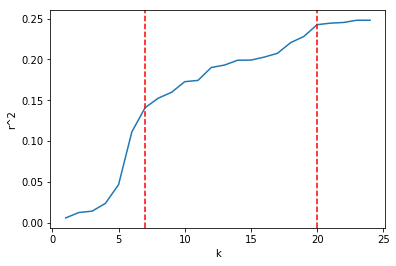

In [186]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=7, color = 'r', linestyle = '--')
plt.axvline(x=20, color = 'r', linestyle = '--')

"Knees" in the plot at around $k=7$ and $k=20$.

In [187]:
k = 7
linPCA_k7_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    linPCA_k7_results[i] = LinRegression(linpcaZ, y, autocor = 2)

In [188]:
linPCA_k7_results

array([0.1735926 , 0.09168991, 0.07303175, 0.13265433, 0.14085989])

In [189]:
k = 20
linPCA_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    linPCA_k20_results[i] = LinRegression(linpcaZ, y, autocor = 2)

In [190]:
np.round(linPCA_k20_results,2)

array([0.29, 0.22, 0.2 , 0.24, 0.24])

Kernel PCA

In [191]:
# Polynomial kernel
k = 7
gamma = 1
degree = 2
poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
LinRegression(poly_kpcaZ, y)

0.016011521530103767

In [192]:
gamma = 1
degree = 2
r_2 = np.zeros(24)
for i in range(1, 25):
    k=i
    poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
    r_2[i-1]=LinRegression(poly_kpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

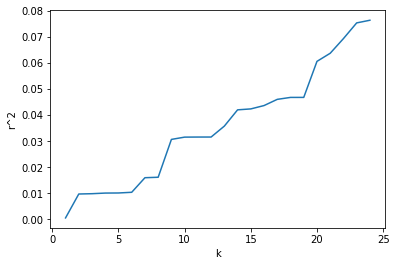

In [193]:
sns.lineplot(x='k',y='r^2',data=r_2)

With polynomial kernel w/ 2 degrees, steady increase with more components.

In [194]:
k=24
degree = 2
r_2 = np.zeros(50)
vals= np.linspace(-1, 1, 50)
for i, v in enumerate(vals):
    gamma = v
    poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
    r_2[i]=LinRegression(poly_kpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['gamma'] = vals

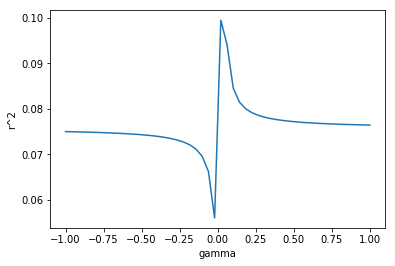

In [195]:
sns.lineplot(x='gamma',y='r^2',data=r_2);

Gamma should be positive, but as close to 0 as possible.

In [196]:
k = 20
gamma = 0.00001
degree = 2
KPCA_poly_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, gamma = gamma, kernel = 'poly', degree = degree))
    KPCA_poly_k20_results[i] = LinRegression(kpcaZ, y)
print(np.round(KPCA_poly_k20_results,3))

[0.289 0.219 0.199 0.246 0.242]


In [197]:
# RBF Kernel
k = 20
gamma = 0.0001
rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='rbf', gamma = gamma))
LinRegression(rbf_kpcaZ, y)
KPCA_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, gamma = gamma, kernel = 'rbf'))
    KPCA_k20_results[i] = LinRegression(kpcaZ, y)
print(np.round(KPCA_k20_results,2))

[0.28 0.21 0.2  0.25 0.22]


Isomap

In [198]:
k_comp = 4
k_nn = 5
isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
LinRegression(isomapZ, y)

0.022929181978184054

In [199]:
k_nn = 5
r_2 = np.zeros(24)
for i in range(1, 25):
    k_comp=i
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
    r_2[i-1]=LinRegression(isomapZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

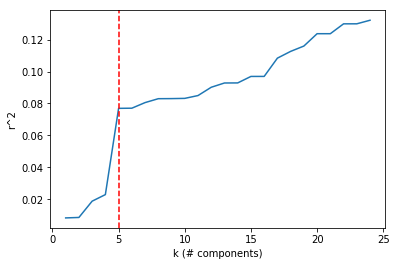

In [200]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=5, color = 'r', linestyle = '--')
plt.xlabel('k (# components)');

Big gains at $k=5$, linear thereafter.

In [201]:
k_comp = 5
r_2 = np.zeros(50)
for i in range(1, 51):
    k_nn=i
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
    r_2[i-1]=LinRegression(isomapZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,51)

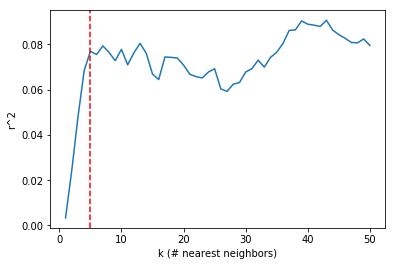

In [202]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=5, color = 'r', linestyle = '--')
plt.xlabel('k (# nearest neighbors)');

Again, big gains at $k=5$, unclear after that.

In [203]:
k = 20
nebs = 47
isomap_k7_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k, n_neighbors = nebs))
    isomap_k7_results[i] = LinRegression(isomapZ, y)
isomap_k7_results

array([0.24586509, 0.16389981, 0.15618824, 0.20639306, 0.15787926])

Spectral Embedding

In [204]:
k_comp = 24
k_nn = 6
affinity = 'nearest_neighbors'
spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity=affinity))
LinRegression(spectralZ, y)

0.08003289094716293

In [205]:
k_nn= 6
affinity = 'nearest_neighbors'
r_2 = np.zeros(24)
for i in range(1, 25):
    k_comp=i
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    r_2[i-1]=LinRegression(spectralZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

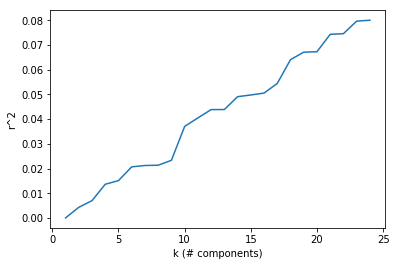

In [206]:
sns.lineplot(x='k',y='r^2',data=r_2);
plt.xlabel('k (# components)');

Steady linear increase with increasing components.

In [207]:
k_comp = 10
affinity = 'nearest_neighbors'
r_2 = np.zeros(50)
for i in range(2,51):
    k_nn=i
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    r_2[i-1]=LinRegression(spectralZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,51)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


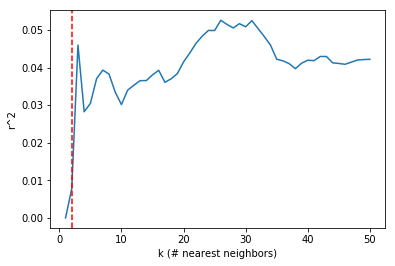

In [208]:
sns.lineplot(x='k',y='r^2',data=r_2);
plt.xlabel('k (# nearest neighbors)');
plt.axvline(x=2, color = 'r', linestyle = '--');

Stark gains at $k=2$; highly variable after that, but general trend upwards

In [209]:
k_comp= 20
k_nn = 3
affinity = 'nearest_neighbors'
spectral_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    spectral_results[i] = LinRegression(spectralZ, y)
print(np.round(spectral_results,2))

[0.1  0.08 0.08 0.09 0.06]


Training dev test split. 3 methods:
- Direct in time (first half is train, next quarter dev, last quarter test)
- Time, but split 75%/25%. Last quarter is test, train/dev is random split of first three quarters
- Completely random

In [24]:
#Split in time
X_train_time = together_df.iloc[:303,:]
X_dev_time = together_df.iloc[303:455,:]
X_test_time = together_df.iloc[455:,:]
y_train_time = stocks_spx.iloc[:303,:]
y_dev_time = stocks_spx.iloc[303:455,:]
y_test_time = stocks_spx.iloc[455:,:]

In [25]:
#Split in time, with train/val split randomly
np.random.seed(2019)
X_train_time_rand = together_df.iloc[:455,:]
y_train_time_rand = stocks_spx.iloc[:455,:]
idx_train, idx_val = np.split(np.random.permutation(len(X_train_time_rand)), [int((2/3)*len(X_train_time_rand))])
X_train_time_rand, X_dev_time_rand = X_train_time_rand.iloc[idx_train,:], X_train_time_rand.iloc[idx_val,:]
y_train_time_rand, y_dev_time_rand = y_train_time_rand.iloc[idx_train,:], y_train_time_rand.iloc[idx_val,:]
X_test_time_rand = together_df.iloc[455:,:]
y_test_time_rand = stocks_spx.iloc[455:,:]

In [26]:
#Random split
idx_train, idx_val, idx_test = np.split(np.random.permutation(len(together_df)),
                                        [int(.5*len(together_df)),int(.75*len(together_df))])
X_train_rand, y_train_rand = together_df.iloc[idx_train,:], stocks_spx.iloc[idx_train,:]
X_dev_rand, y_dev_rand = together_df.iloc[idx_val,:], stocks_spx.iloc[idx_val,:]
X_test_rand, y_test_rand = together_df.iloc[idx_test,:], stocks_spx.iloc[idx_test,:]

Dimensionality reduction techniques: linear PCA as baseline, kernel PCA, and Isomap. Start by tuning hyperparameters for each method, then once we have tuned hyperparameters, get R^2 for linear regression using combined train/dev set for fitting. Then, do same for F-F model (using same train/test split), and compare.

Approach for linear PCA: 1. fit Linear PCA to training set 2. return learned representation of dev set 3. run linear regression using learned dev set and Y 4. return R^2. Note that, for linear regression, the linear regression model is fit to the dev set, not the training set.

TODO:
- hyperparameter tuning plots for all methods (in time) [__DONE__]
- final results table (train + dev, test)

In [27]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
linPCA_results = np.zeros((len(ks),6))
for k in ks:
    linpcaZ = pd.DataFrame(linPCA(X_train, X_dev, n_components=k))
    for i,s in enumerate(y_train_time.columns):
        y = y_dev_time[[s]]
        linPCA_results[k-2,i] = LinRegression(linpcaZ, y)
pca = pd.DataFrame(linPCA_results, index = ks, columns = y_train_time.columns.values).rename_axis('K')
print(pca)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.180440  0.017037  0.021989  0.064478  0.050902  0.211642
3   0.186670  0.044288  0.048825  0.064890  0.117557  0.237577
4   0.210699  0.055649  0.051160  0.070871  0.125498  0.251051
5   0.211130  0.057485  0.055826  0.098019  0.140880  0.307660
6   0.218408  0.071398  0.057363  0.135310  0.149585  0.307667
7   0.223897  0.117533  0.084407  0.194367  0.220926  0.397046
8   0.248113  0.118596  0.092812  0.235532  0.231644  0.448900
9   0.261566  0.128009  0.094646  0.247252  0.241462  0.465921
10  0.263628  0.138741  0.097608  0.293313  0.243703  0.469251
11  0.265440  0.140424  0.126536  0.310713  0.258452  0.471931
12  0.269403  0.173384  0.131553  0.311528  0.277607  0.473927
13  0.271462  0.243271  0.146420  0.363418  0.277792  0.512365
14  0.279928  0.243431  0.148124  0.366195  0.278073  0.546265
15  0.283381  0.243931  0.186125  0.371575  0.303260  0

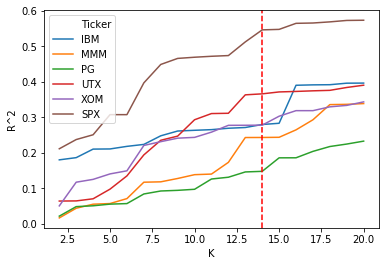

In [214]:
plotPCA=pca.reset_index()
plotPCA = pd.melt(plotPCA, id_vars=['K'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='K',y='R^2',hue = 'Ticker',data=plotPCA);
plt.axvline(x=14, color = 'r', linestyle = '--');
plt.savefig('linPCA_tune.png')

FINAL IN TIME LIN PCA

In [215]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_dev = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
linPCA_results = np.zeros((1,6))
k=14

linpcaZ = pd.DataFrame(linPCA(X_train, X_dev, n_components=k))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    linPCA_results[0,i] = LinRegression(linpcaZ, y)
pca = pd.DataFrame(linPCA_results,index = ['LinearPCA'], columns = y_test_time.columns.values)
print(pca)

                IBM       MMM        PG       UTX       XOM       SPX
LinearPCA  0.450764  0.182046  0.233613  0.382891  0.209839  0.570158


In [216]:
#Split in time, with train/val split randomly
X_train = X_train_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
linPCA_results = np.zeros((len(ks),6))
for k in ks:
    linpcaZ = pd.DataFrame(linPCA(X_train, X_dev, n_components=k))
    for i,s in enumerate(y_train_time_rand.columns):
        y = y_dev_time_rand[[s]]
        linPCA_results[k-2,i] = LinRegression(linpcaZ, y)
print(pd.DataFrame(linPCA_results, index = ks, columns = y_train_time_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.089650  0.111829  0.000442  0.040101  0.002195  0.087573
3   0.118542  0.159121  0.028998  0.090184  0.013194  0.137275
4   0.123375  0.160852  0.035293  0.117458  0.015832  0.150271
5   0.123847  0.161560  0.036698  0.122352  0.029667  0.159272
6   0.150542  0.166679  0.037194  0.140758  0.140821  0.256547
7   0.160150  0.181210  0.037197  0.146834  0.152690  0.297906
8   0.186803  0.274704  0.191370  0.203797  0.298321  0.479742
9   0.200636  0.282610  0.195510  0.244517  0.315887  0.497298
10  0.206007  0.284275  0.230086  0.259247  0.328223  0.500645
11  0.207447  0.284277  0.230856  0.276447  0.362825  0.503228
12  0.207447  0.293034  0.269147  0.278122  0.366971  0.506046
13  0.207579  0.296092  0.269605  0.278122  0.367150  0.509841
14  0.212271  0.310326  0.277546  0.294610  0.370737  0.537052
15  0.212999  0.312221  0.282235  0.295952  0.386677  0

In [217]:
#Random split
X_train = X_train_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
linPCA_results = np.zeros((len(ks),6))
for k in ks:
    linpcaZ = pd.DataFrame(linPCA(X_train, X_dev, n_components=k))
    for i,s in enumerate(y_train_rand.columns):
        y = y_dev_rand[[s]]
        linPCA_results[k-2,i] = LinRegression(linpcaZ, y)
print(pd.DataFrame(linPCA_results, index = ks, columns = y_train_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.141900  0.040913  0.107862  0.125023  0.042647  0.102466
3   0.158416  0.052633  0.126219  0.160716  0.042663  0.103840
4   0.170918  0.053268  0.157808  0.194193  0.098964  0.142630
5   0.233233  0.058825  0.164317  0.195394  0.125747  0.142783
6   0.253479  0.061239  0.164978  0.195934  0.135089  0.155580
7   0.284037  0.111389  0.188968  0.222852  0.174448  0.291593
8   0.298293  0.113863  0.191788  0.230961  0.174553  0.299150
9   0.394266  0.136113  0.199482  0.262370  0.185274  0.333198
10  0.401252  0.139410  0.204923  0.268954  0.185442  0.333200
11  0.404045  0.140129  0.206207  0.269800  0.187076  0.333409
12  0.420606  0.142191  0.211599  0.287617  0.191708  0.335036
13  0.427716  0.145968  0.222451  0.289721  0.192064  0.340309
14  0.431414  0.157673  0.245064  0.294189  0.200971  0.374770
15  0.431445  0.159176  0.247708  0.297386  0.202669  0

RBF KPCA

In [222]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
kernelPCA_results = np.zeros((len(ks),6))
gamma = .0001
for k in ks:
    rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_dev, n_components=k, kernel='rbf', gamma = gamma))
    for i,s in enumerate(y_train_time.columns):
        y = y_dev_time[[s]]
        kernelPCA_results[k-2,i] = LinRegression(rbf_kpcaZ, y)
RBFKPCA = pd.DataFrame(kernelPCA_results, index = ks, columns = y_train_time.columns.values).rename_axis('K')
print(RBFKPCA)

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.178081  0.026836  0.023811  0.077306  0.047613  0.220907
3   0.182677  0.052134  0.049928  0.077546  0.110919  0.236106
4   0.222608  0.066336  0.056958  0.077836  0.118277  0.257074
5   0.223482  0.066368  0.068955  0.108816  0.127003  0.324890
6   0.247573  0.073824  0.069213  0.165095  0.130689  0.325050
7   0.254743  0.119474  0.106776  0.216350  0.212438  0.400510
8   0.267552  0.119661  0.119017  0.252875  0.220354  0.457877
9   0.268140  0.126343  0.120225  0.253247  0.230863  0.461852
10  0.273381  0.135555  0.120722  0.303631  0.231298  0.470341
11  0.274100  0.144456  0.151697  0.304316  0.245994  0.472762
12  0.284226  0.169457  0.153133  0.311743  0.251447  0.476126
13  0.289977  0.172641  0.157131  0.327685  0.265912  0.476497
14  0.297365  0.241379  0.168478  0.383242  0.266718  0.508145
15  0.297589  0.249095  0.171021  0.395085  0.266949  0

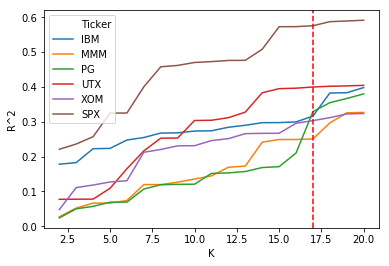

In [225]:
plotRBFKPCA=RBFKPCA.reset_index()
plotRBFKPCA = pd.melt(plotRBFKPCA, id_vars=['K'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='K',y='R^2',hue = 'Ticker',data=plotRBFKPCA);
plt.axvline(x=17, color = 'r', linestyle = '--');
plt.savefig('KPCA_tune.png')

In [65]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
gs = np.linspace(0.00000001,1.5, 20)
kernelPCA_results = np.zeros((len(gs),6))
k=14
for j, g in enumerate(gs):
    rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_dev, n_components=k, kernel='rbf', gamma = g))
    for i,s in enumerate(y_train_time.columns):
        y = y_dev_time[[s]]
        kernelPCA_results[j,i] = LinRegression(rbf_kpcaZ, y)
RBFKPCA = pd.DataFrame(kernelPCA_results, index = gs, columns = y_train_time.columns.values).rename_axis('gamma')
print(RBFKPCA)

                   IBM       MMM        PG       UTX       XOM       SPX
gamma                                                                   
1.000000e-08  0.279931  0.243433  0.148126  0.366201  0.278072  0.546271
7.894738e-02  0.046050  0.067708  0.024848  0.050378  0.058371  0.043688
1.578947e-01  0.045402  0.093581  0.029972  0.044719  0.058204  0.050989
2.368421e-01  0.049085  0.091373  0.029931  0.042072  0.060744  0.050719
3.157895e-01  0.049680  0.090436  0.028439  0.043745  0.061024  0.051361
3.947368e-01  0.048264  0.089112  0.026573  0.046531  0.060704  0.052156
4.736842e-01  0.032016  0.061739  0.023315  0.026652  0.043510  0.042270
5.526316e-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
6.315790e-01  0.024149  0.050035  0.013988  0.022236  0.023341  0.027736
7.105263e-01  0.009217  0.024772  0.009351  0.014388  0.014456  0.016117
7.894737e-01  0.006498  0.007833  0.005887  0.010515  0.007708  0.001835
8.684211e-01  0.005286  0.001230  0.004364  0.00183

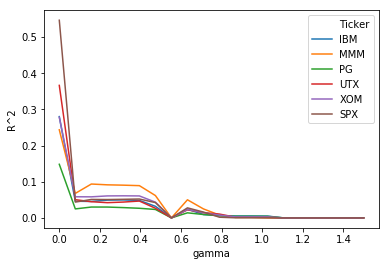

In [66]:
plotRBFKPCA=RBFKPCA.reset_index()
plotRBFKPCA = pd.melt(plotRBFKPCA, id_vars=['gamma'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='gamma',y='R^2',hue = 'Ticker',data=plotRBFKPCA);

In [67]:
#Split in time, with train/val split randomly
X_train = X_train_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
kernelPCA_results = np.zeros((len(ks),6))
gamma = .0000001
for k in ks:
    rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_dev, n_components=k, kernel='rbf', gamma = gamma))
    for i,s in enumerate(y_train_time_rand.columns):
        y = y_dev_time_rand[[s]]
        kernelPCA_results[k-2,i] = LinRegression(rbf_kpcaZ, y)
print(pd.DataFrame(kernelPCA_results, index = ks, columns = y_train_time_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.089643  0.111839  0.000443  0.040098  0.002192  0.087568
3   0.118534  0.159116  0.028995  0.090178  0.013186  0.137269
4   0.123369  0.160851  0.035291  0.117463  0.015824  0.150269
5   0.123841  0.161558  0.036696  0.122364  0.029654  0.159280
6   0.150530  0.166676  0.037192  0.140759  0.140796  0.256535
7   0.160126  0.181199  0.037195  0.146829  0.152648  0.297859
8   0.186779  0.274701  0.191378  0.203800  0.298317  0.479739
9   0.200623  0.282600  0.195520  0.244485  0.315855  0.497270
10  0.205995  0.284265  0.230098  0.259225  0.328201  0.500618
11  0.207436  0.284267  0.230864  0.276430  0.362838  0.503208
12  0.207436  0.293026  0.269138  0.278102  0.366985  0.506030
13  0.207568  0.296087  0.269593  0.278103  0.367165  0.509828
14  0.212261  0.310319  0.277539  0.294583  0.370750  0.537037
15  0.212989  0.312210  0.282238  0.295923  0.386695  0

In [68]:
#Random split
X_train = X_train_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
kernelPCA_results = np.zeros((len(ks),6))
gamma = .0000001
for k in ks:
    rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_dev, n_components=k, kernel='rbf', gamma = gamma))
    for i,s in enumerate(y_train_rand.columns):
        y = y_dev_rand[[s]]
        kernelPCA_results[k-2,i] = LinRegression(rbf_kpcaZ, y)
print(pd.DataFrame(kernelPCA_results, index = ks, columns = y_train_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.141897  0.040913  0.107861  0.125022  0.042640  0.102469
3   0.158414  0.052635  0.126219  0.160710  0.042655  0.103841
4   0.170912  0.053269  0.157814  0.194179  0.098961  0.142628
5   0.233220  0.058825  0.164326  0.195381  0.125745  0.142781
6   0.253477  0.061242  0.164990  0.195922  0.135097  0.155587
7   0.284038  0.111402  0.188977  0.222840  0.174457  0.291607
8   0.298301  0.113877  0.191795  0.230941  0.174562  0.299172
9   0.394260  0.136127  0.199486  0.262352  0.185281  0.333218
10  0.401254  0.139425  0.204921  0.268940  0.185449  0.333221
11  0.404047  0.140146  0.206204  0.269783  0.187083  0.333430
12  0.420598  0.142207  0.211593  0.287608  0.191718  0.335056
13  0.427663  0.145924  0.222302  0.289683  0.192058  0.340207
14  0.431407  0.157696  0.245058  0.294182  0.200983  0.374795
15  0.431438  0.159204  0.247700  0.297383  0.202676  0

FINAL TEST

In [69]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_test = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
kernelPCA_results = np.zeros((1,6))
k=14
gamma = .0000001
rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_test, n_components=k, kernel='rbf', gamma = gamma))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    kernelPCA_results[0,i] = LinRegression(rbf_kpcaZ, y)
kpca_rbf=pd.DataFrame(kernelPCA_results, index = ['KPCA'],columns = y_train_time.columns.values)
print(kpca_rbf)

           IBM       MMM        PG       UTX       XOM       SPX
KPCA  0.450746  0.182039  0.233612  0.382872  0.209839  0.570154


Isomap

In [32]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
isomap_results = np.zeros((len(ks),6))
k_nn = 24
for k in ks:
    isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k, n_neighbors=k_nn))
    for i,s in enumerate(y_train_time.columns):
        y = y_dev_time[[s]]
        isomap_results[k-2,i] = LinRegression(isomapZ, y)
isomapdf = pd.DataFrame(isomap_results, index = ks, columns = y_train_time.columns.values).rename_axis('K')
print(isomapdf)

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.170302  0.012815  0.015088  0.058971  0.044473  0.191233
3   0.171445  0.038104  0.040232  0.059471  0.114543  0.204422
4   0.184307  0.044204  0.040629  0.064818  0.122158  0.248313
5   0.197329  0.046614  0.041250  0.067296  0.122668  0.277877
6   0.197908  0.051142  0.086493  0.067488  0.122997  0.284802
7   0.197984  0.051142  0.112119  0.072972  0.124008  0.284876
8   0.210307  0.093735  0.119017  0.075099  0.128254  0.289089
9   0.221975  0.093738  0.179901  0.125527  0.132230  0.320918
10  0.228701  0.096419  0.193947  0.131829  0.181621  0.331671
11  0.236475  0.103682  0.199135  0.155921  0.181746  0.352664
12  0.242324  0.107506  0.210817  0.158625  0.183204  0.390415
13  0.264516  0.114626  0.212732  0.207079  0.197732  0.425328
14  0.268417  0.115035  0.215886  0.218562  0.209524  0.425608
15  0.289359  0.115186  0.222503  0.221551  0.210019  0

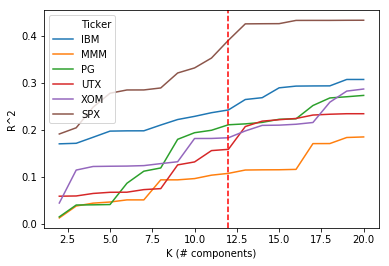

In [34]:
plotisomap=isomapdf.reset_index()
plotisomap = pd.melt(plotisomap, id_vars=['K'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='K',y='R^2',hue = 'Ticker',data=plotisomap);
plt.xlabel('K (# components)');
plt.axvline(x=12, color = 'r', linestyle = '--');
plt.savefig('isomap_tune.png')

In [72]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,100)
isomap_results = np.zeros((len(ks),6))
k_comp = 12
for k in ks:
    isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k_comp, n_neighbors=k))
    for i,s in enumerate(y_train_time.columns):
        y = y_dev_time[[s]]
        isomap_results[k-2,i] = LinRegression(isomapZ, y)
isomapdf = pd.DataFrame(isomap_results, index = ks, columns = y_train_time.columns.values).rename_axis('K')
print(isomapdf)

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.136122  0.084895  0.143914  0.120603  0.119922  0.236916
3   0.249464  0.079096  0.159126  0.090808  0.135674  0.243430
4   0.224260  0.074964  0.133714  0.097749  0.154521  0.269565
5   0.226646  0.074901  0.156439  0.099774  0.119533  0.292826
6   0.209839  0.051920  0.159903  0.086045  0.107447  0.320347
7   0.223870  0.076471  0.174817  0.098673  0.104293  0.323584
8   0.225076  0.064664  0.179913  0.118065  0.131469  0.325614
9   0.217729  0.075773  0.152762  0.097511  0.119016  0.320663
10  0.220562  0.071407  0.187970  0.115101  0.123158  0.317305
11  0.216041  0.114235  0.162402  0.104543  0.143973  0.310736
12  0.240278  0.151724  0.130345  0.153497  0.161998  0.331195
13  0.251628  0.139863  0.125846  0.146264  0.156297  0.326468
14  0.245859  0.145979  0.128632  0.135866  0.145631  0.324043
15  0.251191  0.128662  0.132966  0.129181  0.117544  0

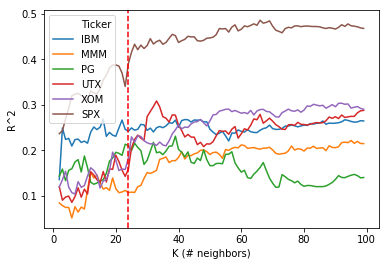

In [73]:
plotisomap=isomapdf.reset_index()
plotisomap = pd.melt(plotisomap, id_vars=['K'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='K',y='R^2',hue = 'Ticker',data=plotisomap);
plt.xlabel('K (# neighbors)');
plt.axvline(x=24, color = 'r', linestyle = '--');

FINAL TEST

In [74]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_dev = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
isomap_results = np.zeros((1,6))
k_comp = 12
k_nn = 24
isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k_comp, n_neighbors=k_nn))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    isomap_results[0,i] = LinRegression(isomapZ, y)
isomapdf = pd.DataFrame(isomap_results, index = ['Isomap'], columns = y_train_time.columns.values)
print(isomapdf)

             IBM       MMM        PG       UTX       XOM      SPX
Isomap  0.406218  0.208697  0.160205  0.371214  0.217296  0.51391


In [75]:
#Split in time, with train/val split randomly
X_train = X_train_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_time_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
isomap_results = np.zeros((len(ks),6))
k_nn = 60
for k in ks:
    isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k, n_neighbors=k_nn))
    for i,s in enumerate(y_train_time_rand.columns):
        y = y_dev_time_rand[[s]]
        isomap_results[k-2,i] = LinRegression(isomapZ, y)
print(pd.DataFrame(isomap_results, index = ks, columns = y_train_time_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.083332  0.102926  0.001589  0.036558  0.003602  0.081377
3   0.125040  0.179583  0.034285  0.110138  0.012128  0.153051
4   0.130439  0.179612  0.045021  0.136509  0.012176  0.168345
5   0.132210  0.183866  0.048213  0.158115  0.054983  0.213447
6   0.164006  0.191271  0.070274  0.162875  0.136889  0.287095
7   0.167031  0.204056  0.071359  0.165192  0.173337  0.318192
8   0.167747  0.204668  0.099838  0.165198  0.175622  0.322321
9   0.169363  0.245023  0.257832  0.166868  0.194130  0.380656
10  0.171541  0.259209  0.290453  0.195501  0.254114  0.442890
11  0.185975  0.269289  0.294806  0.201582  0.273242  0.455951
12  0.195062  0.270206  0.306461  0.251762  0.303106  0.491867
13  0.195063  0.309799  0.315415  0.270980  0.305772  0.508026
14  0.201824  0.319989  0.321202  0.275395  0.316582  0.519957
15  0.202913  0.320098  0.332930  0.276561  0.318034  0

In [76]:
#Random split
X_train = X_train_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
X_dev = X_dev_rand.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
ks = np.arange(2,21)
kernelPCA_results = np.zeros((len(ks),6))
isomap_results = np.zeros((len(ks),6))
k_nn = 60
for k in ks:
    isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k, n_neighbors=k_nn))
    for i,s in enumerate(y_train_rand.columns):
        y = y_dev_rand[[s]]
        isomap_results[k-2,i] = LinRegression(isomapZ, y)
print(pd.DataFrame(isomap_results, index = ks, columns = y_train_rand.columns.values).rename_axis('K'))

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.147892  0.045935  0.097042  0.137927  0.036786  0.108037
3   0.168721  0.052297  0.130056  0.158752  0.037842  0.124400
4   0.186849  0.055142  0.143340  0.203599  0.109124  0.148733
5   0.242307  0.062361  0.149670  0.204878  0.123360  0.149047
6   0.294767  0.074133  0.157501  0.208976  0.141900  0.178987
7   0.295955  0.078038  0.192529  0.236732  0.150052  0.221707
8   0.370793  0.093304  0.201730  0.261277  0.184516  0.283403
9   0.373381  0.101666  0.203679  0.271710  0.187762  0.308427
10  0.373572  0.101724  0.207753  0.271866  0.198683  0.309789
11  0.406593  0.105195  0.209153  0.277174  0.215300  0.321079
12  0.418862  0.140020  0.209358  0.277292  0.216733  0.334213
13  0.428722  0.146172  0.224796  0.284434  0.217844  0.334689
14  0.460867  0.160085  0.232531  0.322509  0.240039  0.363102
15  0.460985  0.162362  0.241457  0.323877  0.254847  0

Spectral Embedding

In [38]:
#Split in time
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
ks = np.arange(2,21)
spectral_results = np.zeros((len(ks),6))
k_nn = 6
affinity = 'nearest_neighbors'
for k in ks:
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k, n_neighbors=k_nn, affinity=affinity))
    for i,s in enumerate(y_train_time.columns):
        y = y_train_time[[s]].append(y_dev_time[[s]])
        spectral_results[k-2,i] = LinRegression(spectralZ, y)
spectraldf = pd.DataFrame(spectral_results, index = ks, columns = y_train_time.columns.values).rename_axis('K')
print(spectraldf)

         IBM       MMM        PG       UTX       XOM       SPX
K                                                             
2   0.053724  0.040218  0.058583  0.020854  0.009956  0.056341
3   0.076475  0.047910  0.062836  0.043268  0.019236  0.071889
4   0.085013  0.048739  0.068265  0.055748  0.021285  0.076659
5   0.090033  0.048756  0.068611  0.057736  0.025515  0.082714
6   0.097879  0.048794  0.068863  0.058577  0.027043  0.086507
7   0.115339  0.050216  0.075643  0.058976  0.028282  0.086792
8   0.119512  0.057437  0.075770  0.063511  0.033926  0.089379
9   0.123287  0.058546  0.075776  0.069290  0.035077  0.091150
10  0.124667  0.058578  0.075983  0.071508  0.035670  0.098803
11  0.127509  0.063104  0.076502  0.075947  0.036861  0.100951
12  0.130896  0.063812  0.077787  0.078100  0.039542  0.102020
13  0.143697  0.082471  0.086709  0.084481  0.069264  0.133591
14  0.144367  0.089281  0.086810  0.090732  0.077494  0.136283
15  0.145251  0.089729  0.092949  0.094060  0.084465  0

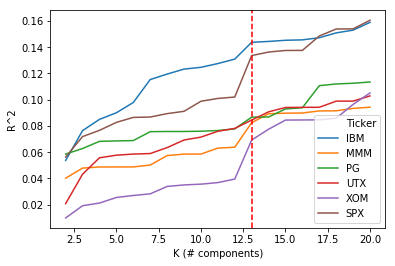

In [43]:
plotspectral=spectraldf.reset_index()
plotspectral = pd.melt(plotspectral, id_vars=['K'], value_vars=['IBM', 'MMM','PG','UTX','XOM','SPX'],
                      var_name='Ticker',value_name = 'R^2')
ax=sns.lineplot(x='K',y='R^2',hue = 'Ticker',data=plotspectral);
plt.xlabel('K (# components)');
plt.axvline(x=13, color = 'r', linestyle = '--');
plt.savefig('spectral_tune.png')

FF Factor Models

In [77]:
#Split in time - FF5
X_train = X_train_time[['SMB','HML','RMW','CMA',"Mkt-RF"]].append(X_dev_time[['SMB','HML','RMW','CMA',"Mkt-RF"]])
X_dev = X_test_time[['SMB','HML','RMW','CMA',"Mkt-RF"]]
ff5 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time[[s]].append(y_dev_time[[s]])
    y = y_test_time[[s]]
    ff5[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
ff5_df = pd.DataFrame(ff5, index = ['FF5'],columns = y_train_time.columns.values)
print(ff5_df)

          IBM       MMM        PG       UTX       XOM       SPX
FF5  0.350321  0.409447  0.106694  0.494025  0.207206  0.986028


In [78]:
#Split in time - FF3
X_train = X_train_time[['SMB','HML','Mkt-RF']].append(X_dev_time[['SMB','HML','Mkt-RF']])
X_dev = X_test_time[['SMB','HML','Mkt-RF']]
ff3 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time[[s]].append(y_dev_time[[s]])
    y = y_test_time[[s]]
    ff3[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
ff3_df = pd.DataFrame(ff3, index = ['FF3'],columns = y_train_time.columns.values)
print(ff3_df)

          IBM       MMM        PG       UTX       XOM       SPX
FF3  0.426857  0.373947  0.049076  0.504265  0.202096  0.988266


In [80]:
#Split in time, with train/val split randomly - FF5
X_train = X_train_time_rand[['SMB','HML','RMW','CMA',"Mkt-RF"]]
X_dev = X_test_time_rand[['SMB','HML','RMW','CMA',"Mkt-RF"]]
ff5 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time_rand[[s]]
    y = y_test_time_rand[[s]]
    ff5[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
print(pd.DataFrame(ff5, columns = y_train_time_rand.columns.values))

        IBM       MMM        PG       UTX      XOM       SPX
0  0.335889  0.402518  0.146558  0.467956  0.22437  0.986211


In [81]:
#Split in time, with train/val split randomly - FF3
X_train = X_train_time_rand[['SMB','HML','RMW','CMA',"Mkt-RF"]]
X_dev = X_dev_time_rand[['SMB','HML','RMW','CMA',"Mkt-RF"]]
ff5 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time_rand[[s]]
    y = y_dev_time_rand[[s]]
    ff5[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
print(pd.DataFrame(ff5, columns = y_train_time_rand.columns.values))

        IBM       MMM        PG       UTX      XOM       SPX
0  0.342301  0.380555  0.189116  0.355426  0.43029  0.993259


### AGGREGATED RESULTS

In [82]:
## LINEAR PCA
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_dev = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
linPCA_results = np.zeros((1,6))

k=14

linpcaZ = pd.DataFrame(linPCA(X_train, X_dev, n_components=k))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    linPCA_results[0,i] = LinRegression(linpcaZ, y)
pca = pd.DataFrame(linPCA_results,index = ['LinearPCA'], columns = y_test_time.columns.values)

In [83]:
## RBF KERNEL PCA
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_test = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
kernelPCA_results = np.zeros((1,6))
k=14
gamma = .0000001
rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_test, n_components=k, kernel='rbf', gamma = gamma))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    kernelPCA_results[0,i] = LinRegression(rbf_kpcaZ, y)
kpca_rbf=pd.DataFrame(kernelPCA_results, index = ['KPCA'],columns = y_train_time.columns.values)

In [84]:
# ISOMAP
X_train = X_train_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1).append(X_dev_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1))
X_dev = X_test_time.drop(['Month','SMB','HML','RMW','CMA',"Mkt-RF",'RF'],axis=1)
isomap_results = np.zeros((1,6))
k_comp = 12
k_nn = 24
isomapZ = pd.DataFrame(isomap(X_train, X_dev, n_components=k_comp, n_neighbors=k_nn))
for i,s in enumerate(y_train_time.columns):
    y = y_test_time[[s]]
    isomap_results[0,i] = LinRegression(isomapZ, y)
isomapdf = pd.DataFrame(isomap_results, index = ['Isomap'], columns = y_train_time.columns.values)

In [85]:
#FAMA FRENCH 3 FACTORS
X_train = X_train_time[['SMB','HML','Mkt-RF']].append(X_dev_time[['SMB','HML','Mkt-RF']])
X_dev = X_test_time[['SMB','HML','Mkt-RF']]
ff3 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time[[s]].append(y_dev_time[[s]])
    y = y_test_time[[s]]
    ff3[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
ff3_df = pd.DataFrame(ff3, index = ['FF3'],columns = y_train_time.columns.values)

In [86]:
#FAMA FRENCH 5 FACTORS
X_train = X_train_time[['SMB','HML','RMW','CMA',"Mkt-RF"]].append(X_dev_time[['SMB','HML','RMW','CMA',"Mkt-RF"]])
X_dev = X_test_time[['SMB','HML','RMW','CMA',"Mkt-RF"]]
ff5 = np.zeros((1,6))
for i,s in enumerate(y_train_time.columns):
    y_train = y_train_time[[s]].append(y_dev_time[[s]])
    y = y_test_time[[s]]
    ff5[0,i] = LinRegression(X_train, y_train,dev = True, X_test = X_dev, y_test = y)
ff5_df = pd.DataFrame(ff5, index = ['FF5'],columns = y_train_time.columns.values)

In [87]:
total_df = ff3_df.append(ff5_df.append(pca.append(kpca_rbf.append(isomapdf))))
total_df.reset_index(inplace=True)
total_df.rename(columns={"index":"method"}, inplace=True)
total_df

,method,IBM,MMM,PG,UTX,XOM,SPX
0,FF3,0.426857,0.373947,0.049076,0.504265,0.202096,0.988266
1,FF5,0.350321,0.409447,0.106694,0.494025,0.207206,0.986028
2,LinearPCA,0.450764,0.182046,0.233613,0.382891,0.209839,0.570158
3,KPCA,0.450746,0.182039,0.233612,0.382872,0.209839,0.570154
4,Isomap,0.406218,0.208697,0.160205,0.371214,0.217296,0.513910


In [226]:
total_df.to_excel('results.xlsx')

In [88]:
ibm_results = total_df[['method','IBM']]
mmm_results = total_df[['method','MMM']]
pg_results = total_df[['method','PG']]
utx_results = total_df[['method','UTX']]
xom_results = total_df[['method','XOM']]
spx_results = total_df[['method','SPX']]